In [1]:
from __future__ import division
from glob import glob
import tensorflow as tf
from tensorflow import keras
import random
import nrrd
import numpy as np
import time
from data_gen import CTA
from tensorflow.python.client import device_lib
from Networks import model_unet16, model_unet16csam, model_unet176, model_unet176csam, model_unet352
import skimage
import patchify
from helper_funcs import *

Config paths and mixed precision for reduced memory
Load model

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\bernh\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\client\session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

training_dir = "./training_data/train_z128_iso_win_im/"
label_dir = "./training_data/train_z128_iso_win_la/"
data_list =glob('{}/*.nrrd'.format(training_dir))
label_list=glob('{}/*.nrrd'.format(label_dir))

policy = keras.mixed_precision.Policy('mixed_float16')
keras.mixed_precision.set_global_policy(policy)

keras.backend.clear_session()

img_size = (256, 256, 128)
model = model_classic_unet_176.get_model(img_size)
a=model.summary(line_length=150)



Num GPUs Available:  1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070, compute capability 7.5
(None, 256, 256, 128, 1)
Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 256, 256, 128, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d (Conv3D)                                  (None, 256, 256, 128, 8)         224       

Split data into training and validation set
Initialise sequence

In [4]:
val_samples = int(np.floor(len(data_list)*0.3))
random.Random(7331).shuffle(data_list)
random.Random(7331).shuffle(label_list)

train_img_paths = data_list[:-val_samples]
train_lab_paths = label_list[:-val_samples]

val_img_paths = data_list[-val_samples:]
val_lab_paths = label_list[-val_samples:]

train_gen = CTA(train_img_paths, train_lab_paths, 1)
valid_gen = CTA(val_img_paths, val_lab_paths, 1)

Enable dynamic memory allocation

Compile model
Add callback to check loss inside of epoch
train model

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001, epsilon=0.01), loss=[neg_dice_coef])
epochs = 300

callbacks = [
    keras.callbacks.EarlyStopping(patience=20, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00000001, verbose=1),
    keras.callbacks.ModelCheckpoint("classic_unet_176.h5", verbose=1, save_best_only=True)
]
start = time.time()
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callbacks,shuffle=True)
end = time.time()
print('Training time: ', end-start)

Epoch 1/300
175/175 [==============================] - 225s 1s/step - loss: -88666.8438 - val_loss: -89421.3125

Epoch 00001: val_loss improved from inf to -89421.31250, saving model to classic_unet_176.h5
Epoch 2/300
175/175 [==============================] - 184s 1s/step - loss: -96486.1406 - val_loss: -96276.9297

Epoch 00002: val_loss improved from -89421.31250 to -96276.92969, saving model to classic_unet_176.h5
Epoch 3/300
175/175 [==============================] - 187s 1s/step - loss: -98369.5391 - val_loss: -98490.2422

Epoch 00003: val_loss improved from -96276.92969 to -98490.24219, saving model to classic_unet_176.h5
Epoch 4/300
175/175 [==============================] - 185s 1s/step - loss: -99015.3828 - val_loss: -99095.6797

Epoch 00004: val_loss improved from -98490.24219 to -99095.67969, saving model to classic_unet_176.h5
Epoch 5/300
175/175 [==============================] - 184s 1s/step - loss: -99299.3828 - val_loss: -99087.4688

Epoch 00005: val_loss did not improv

Text(0, 0.5, 'Dice loss')

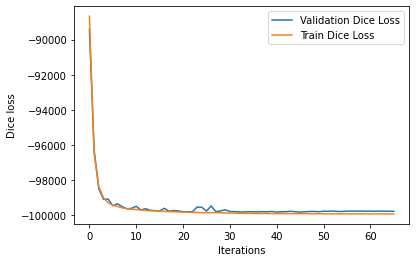

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['val_loss'], label='Validation Dice Loss')
plt.plot(history.history['loss'], label='Train Dice Loss')
#plt.plot(batch_loss.losses)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Dice loss')

Testing

In [80]:
filename = "D3"
test_img, header = nrrd.read('./test_data/D3_resamp.nrrd')
x, y, z = test_img.shape
m_x = x//2
m_y = y//2
image = test_img[m_x-128:m_x+128,m_y-128:m_y+128,:]
if filename[0] == 'D':
    im_win = np.where(image<100,0, image)
    im_win = np.where(image>700,0, im_win)
elif filename[0] == 'K':
    im_win = np.where(image<1100,0, image)
    im_win = np.where(image>2000,0, im_win)
else:
    im_win = np.where(image<1100,0, image)
    im_win = np.where(image>1350,0, im_win)

image_norm = (im_win - np.min(im_win))/(np.max(im_win)-np.min(im_win))
patch_shape =(256, 256, 128)
image_pad = z_padding(image_norm)
test_patches=patchify.patchify(image_pad, (256,256,128), step=128)
pat_size = test_patches.shape
test_patches = test_patches.squeeze()
test_patches = np.expand_dims(test_patches, -1)
pred_patches = np.empty(shape=test_patches.shape)
pred_raw = np.empty(shape=test_patches.shape)
print(test_patches.shape)
for i in np.arange(test_patches.shape[0]):
    pred = model.predict(np.expand_dims(test_patches[i,:,:,:,0],axis=0),batch_size=1, verbose=1)
    pred_raw[i,:,:,:,0]=np.squeeze(pred)
    pred = (pred > 0.005).astype(np.uint8)

    pred = np.squeeze(pred)
    pred_patches[i,:,:,:,0] =  pred

(5, 256, 256, 128, 1)
1/1 [==============================] - 0s 40ms/step


In [81]:
pred_patches=pred_patches.squeeze()
pred_patches = np.expand_dims(np.expand_dims(pred_patches, axis=0),axis=0)
pred_patches_r = pred_raw.squeeze()
pred_patches_r = np.expand_dims(np.expand_dims(pred_patches_r, axis=0), axis=0)
print(pred_patches.shape)


(1, 1, 5, 256, 256, 128)


Reconstruct image from patches

In [82]:
reconstructed = patchify.unpatchify(pred_patches,image_pad.shape)
recon_raw = patchify.unpatchify(pred_patches_r, image_pad.shape)

Morphological operations

In [ ]:
from scipy import ndimage
closed_once = ndimage.binary_closing(reconstructed, iterations=2).astype(int)

Connected components

In [87]:
import cc3d
import nrrd
import numpy as np
labels_out, N = cc3d.connected_components(closed_once, return_N=True)
aorta_label = aorta_id(labels_out)
labels_big = labels_out * (labels_out == aorta_label)
nrrd.write('D3_win_unet_176.seg.nrrd', labels_big)